# 🚀 LangGraph Quickstart
In this tutorial, we will build a support chatbot in LangGraph that can:

✅ Answer common questions by searching the web  
✅ Maintain conversation state across calls  
✅ Route complex queries to a human for review  
✅ Use custom state to control its behavior  
✅ Rewind and explore alternative conversation paths  

We'll start with a basic chatbot and progressively add more sophisticated capabilities, introducing key LangGraph concepts along the way. Let’s dive in! 🌟

In [10]:
import os
from dotenv import load_dotenv
load_dotenv()

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = os.getenv(var)

_set_env("GROQ_API_KEY")

## Part 1: Build a Basic Chatbot

We'll first create a simple chatbot using LangGraph. This chatbot will respond directly to user messages. Though simple, it will illustrate the core concepts of building with LangGraph. By the end of this section, you will have a built rudimentary chatbot.

Start by creating a StateGraph. A StateGraph object defines the structure of our chatbot as a "state machine". We'll add nodes to represent the llm and functions our chatbot can call and edges to specify how the bot should transition between these functions.

In [11]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

Our graph can now handle two key tasks:

- Each node can receive the current State as input and output an update to the state.
- Updates to messages will be appended to the existing list rather than overwriting it, thanks to the prebuilt add_messages function used with the Annotated syntax.

Next, add a "chatbot" node. Nodes represent units of work. They are typically regular python functions.

In [12]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="deepseek-r1-distill-llama-70b",
    #api_key=os.getenv("GROQ_API_KEY")
)

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

Notice how the chatbot node function takes the current State as input and returns a dictionary containing an updated messages list under the key "messages". This is the basic pattern for all LangGraph node functions.

The add_messages function in our State will append the llm's response messages to whatever messages are already in the state.

Next, add an entry point. This tells our graph where to start its work each time we run it.

In [13]:
graph_builder.add_edge(START, "chatbot")

Similarly, set a finish point. This instructs the graph "any time this node is run, you can exit."

In [14]:
graph_builder.add_edge("chatbot", END)

Finally, we'll want to be able to run our graph. To do so, call "compile()" on the graph builder. This creates a "CompiledGraph" we can use invoke on our state.

In [15]:
graph = graph_builder.compile()

You can visualize the graph using the get_graph method and one of the "draw" methods, like draw_ascii or draw_png. The draw methods each require additional dependencies.

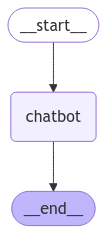

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now let's run the chatbot!

Tip: You can exit the chat loop at any time by typing "quit", "exit", or "q".

In [17]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: <think>

</think>

Hello! How can I assist you today? 😊
Goodbye!


## Part 2: 🛠️ Enhancing the Chatbot with Tools

To handle queries our chatbot can't answer "from memory", we'll integrate a web search tool. Our bot can use this tool to find relevant information and provide better responses.

In [18]:
_set_env("TAVILY_API_KEY")

In [19]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': 'Nodes: Nodes represent units of work within your LangGraph. They are typically Python functions that perform a specific task, such as:.'},
 {'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step . You define nodes to perform'}]

The results are page summaries our chat bot can use to answer questions.

Next, we'll start defining our graph. The following is all the same as in Part 1, except we have added bind_tools on our LLM. This lets the LLM know the correct JSON format to use if it wants to use our search engine.

In [20]:
from typing import Annotated
from typing_extensions import TypedDict

from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)


llm = ChatGroq(
    model="deepseek-r1-distill-llama-70b",
    #api_key=os.getenv("GROQ_API_KEY")
)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

Next we need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node.

Below, we implement a BasicToolNode that checks the most recent message in the state and calls tools if the message contains tool_calls. It relies on the LLM's tool_calling support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

We will later replace this with LangGraph's prebuilt ToolNode to speed things up, but building it ourselves first is instructive.

In [21]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [22]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

Notice that conditional edges start from a single node. This tells the graph "any time the 'chatbot' node runs, either go to 'tools' if it calls a tool, or end the loop if it responds directly.

Like the prebuilt tools_condition, our function returns the END string if no tool calls are made. When the graph transitions to END, it has no more tasks to complete and ceases execution. Because the condition can return END, we don't need to explicitly set a finish_point this time. Our graph already has a way to finish!

Let's visualize the graph we've built. The following function has some additional dependencies to run that are unimportant for this tutorial.

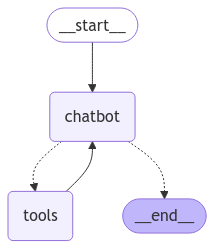

In [23]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now we can ask the bot questions outside its training data.

In [24]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: [{"url": "https://en.wikipedia.org/wiki/Hello_(Adele_song)", "content": "Several publications have commented on similarities in the theme of the song and accompanying video with that of \"Hello\" by American singer Lionel Richie.[29][30]\nIn 2021, Parade ranked the song number 12 on their list of the 25 greatest Adele songs,[31] and in 2022, American Songwriter ranked the song number three on their list of the 10 greatest Adele songs.[32]\nChart performance[edit]\nEurope and Oceania[edit]\nThree days after its release, the Official Charts Company announced that \"Hello\" had accumulated 165,000 chart sales in the United Kingdom, of which 156,000 were downloads.[33] \"Hello\" entered at the top of the UK Singles Chart on 30 October 2015,\u00a0\u2013\nfor the week dated 5 November 2015\u00a0\u2013\nwith 333,000 combined sales, of which 259,000 were downloads, making it the biggest selling number-one single on the chart in three years. \"\n\u2014 Xavier Dolan, behin

Congrats! You've created a conversational agent in langgraph that can use a search engine to retrieve updated information when needed. Now it can handle a wider range of user queries. To inspect all the steps your agent just took, check out this LangSmith trace.
Our chatbot still can't remember past interactions on its own, limiting its ability to have coherent, multi-turn conversations. In the next part, we'll add memory to address this.

The full code for the graph we've created in this section is reproduced below, replacing our BasicToolNode for the prebuilt ToolNode, and our route_tools condition with the prebuilt tools_condition

In [ ]:
from typing import Annotated
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatGroq(
    model="deepseek-r1-distill-llama-70b",
    #api_key=os.getenv("GROQ_API_KEY")
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

## Part 3: Adding Memory to the Chatbot

Our chatbot can now use tools to answer user questions, but it doesn't remember the context of previous interactions. This limits its ability to have coherent, multi-turn conversations.

LangGraph solves this problem through persistent checkpointing. If you provide a checkpointer when compiling the graph and a thread_id when calling your graph, LangGraph automatically saves the state after each step. When you invoke the graph again using the same thread_id, the graph loads its saved state, allowing the chatbot to pick up where it left off.

We will see later that checkpointing is much more powerful than simple chat memory - it lets you save and resume complex state at any time for error recovery, human-in-the-loop workflows, time travel interactions, and more. But before we get too ahead of ourselves, let's add checkpointing to enable multi-turn conversations.

To get started, create a MemorySaver checkpointer.

In [28]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

Notice we're using an in-memory checkpointer. This is convenient for our tutorial (it saves it all in-memory). In a production application, you would likely change this to use SqliteSaver or PostgresSaver and connect to your own DB.

Next define the graph. Now that you've already built your own BasicToolNode, we'll replace it with LangGraph's prebuilt ToolNode and tools_condition, since these do some nice things like parallel API execution. Apart from that, the following is all copied from Part 2.

In [29]:
from typing import Annotated
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatGroq(
    model="deepseek-r1-distill-llama-70b",
    #api_key=os.getenv("GROQ_API_KEY")
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

Finally, compile the graph with the provided checkpointer.

In [30]:
graph = graph_builder.compile(checkpointer=memory)

Notice the connectivity of the graph hasn't changed since Part 2. All we are doing is checkpointing the State as the graph works through each node.

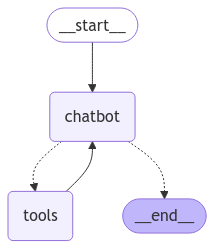

In [31]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [33]:
config = {"configurable": {"thread_id": "1"}}

In [34]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_708z)
 Call ID: call_708z
  Args:
    query: Hi there! My name is Will.
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://medium.com/@Willofwrites/hello-my-name-is-will-fd0bab1ce7e", "content": "Hello, my name is Will · Who I am. I am an active-duty Warrant Officer in the U.S. Army with more than 29 years of service to date. · Why I'm here"}, {"url": "https://www.amazon.com/My-Name-Will-Novel-Shakespeare/dp/B0046LUJ50", "content": "This grad student is saying yes to drugs, bedding coeds, and delivering a giant psychedelic mushroom to a mysterious collector."}]
================================== Ai Message ==================================

Hello, Will! How can I assist y

Note: The config was provided as the second positional argument when calling our graph. It importantly is not nested within the graph inputs ({'messages': []}).
Let's ask a followup: see if it remembers your name.

In [35]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember! You're Will. 😊 How can I assist you today?


In [36]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Of course! Please share your name with me, and I'll remember it for our conversation.


Notice that the only change we've made is to modify the thread_id in the config. See this call's LangSmith trace for comparison.
By now, we have made a few checkpoints across two different threads. But what goes into a checkpoint? To inspect a graph's state for a given config at any time, call get_state(config).

In [37]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='44711c24-f5e0-430c-9b10-545f1307283d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_708z', 'function': {'arguments': '{"query":"Hi there! My name is Will."}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 236, 'prompt_tokens': 167, 'total_tokens': 403, 'completion_time': 0.858181818, 'prompt_time': 0.012136454, 'queue_time': 0.251610403, 'total_time': 0.870318272}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_95405939f8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-378056a4-f6ef-4c59-969c-5a38c7a996ea-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Hi there! My name is Will.'}, 'id': 'call_708z', 'type': 'tool_call'}], usage_metadata={'input_tokens': 167, 'output_tokens': 236, 'total_tokens':

In [38]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()

The snapshot above contains the current state values, corresponding config, and the next node to process. In our case, the graph has reached an END state, so next is empty.

Congratulations! Your chatbot can now maintain conversation state across sessions thanks to LangGraph's checkpointing system. This opens up exciting possibilities for more natural, contextual interactions. LangGraph's checkpointing even handles arbitrarily complex graph states, which is much more expressive and powerful than simple chat memory.

In the next part, we'll introduce human oversight to our bot to handle situations where it may need guidance or verification before proceeding.

Check out the code snippet below to review our graph from this section.

In [39]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

## Part 4: Human-in-the-loop

Agents can be unreliable and may need human input to successfully accomplish tasks. Similarly, for some actions, you may want to require human approval before running to ensure that everything is running as intended.

LangGraph's persistence layer supports human-in-the-loop workflows, allowing execution to pause and resume based on user feedback. The primary interface to this functionality is the interrupt function. Calling interrupt inside a node will pause execution. Execution can be resumed, together with new input from a human, by passing in a Command. interrupt is ergonomically similar to Python's built-in input(), with some caveats. We demonstrate an example below.

First, start with our existing code from Part 3. We will make one change, which is to add a simple human_assistance tool accessible to the chatbot. This tool uses interrupt to receive information from a human.